In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr

from implicit_filter import LatLonNumpyFilter

# Load file with your data
---
### Open file with data

In [2]:
ds = xr.open_dataset("../t_scaling.nc")
ds

<xarray.Dataset>
Dimensions:    (lon: 5136, lat: 2560)
Coordinates:
  * lon        (lon) float64 0.0 0.07009 0.1402 0.2103 ... 359.8 359.9 359.9
  * lat        (lat) float64 -89.96 -89.89 -89.82 -89.75 ... 89.82 89.89 89.96
Data variables:
    t_scaling  (lat, lon) float32 ...

### Load entire array or relevant part

In [3]:
global_lat = ds.lat.values
global_lon = ds.lon.values
global_tt = ds["t_scaling"].values

europe_lat = ds.lat[1750:2300].values
europe_lon = np.concatenate((ds.lon[-150:].values - 360., ds.lon[:410].values), axis=0)
europe_tt = np.concatenate((ds["t_scaling"][1750:2300, -150:].values, ds["t_scaling"][1750:2300, :410].values), axis=1)

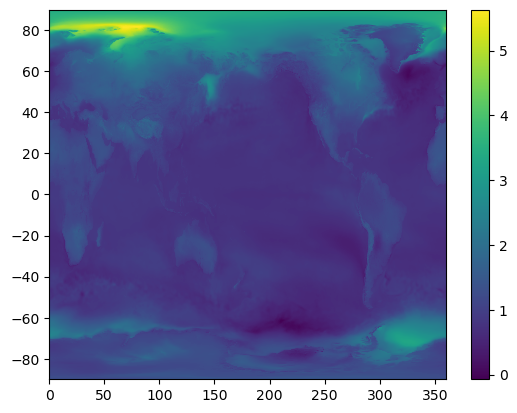

In [27]:
plt.pcolormesh(global_lon, global_lat, global_tt, shading="auto")
plt.colorbar()

# Prepare the filter
---

Prepare filter object for each use case.
When the mesh is non-cartesian it is important to remove from data areas close to the poles.
For those areas, metric terms are close to 0, resulting in filter not converging.

###  For global data let's assume the mesh is flat

In [10]:
global_filter = LatLonNumpyFilter()
global_filter.prepare(global_lon, global_lat, cartesian=True, local=False)

### For local filter let's take into account effects of Earth's shape

In [4]:
europe_filter = LatLonNumpyFilter()
europe_filter.prepare(europe_lon, europe_lat, cartesian=False, local=True)

### Just like for all other filters, auxiliary arrays can be saved and used later

In [5]:
europe_filter.save_to_file("../latlon_cash")
europe_filter = LatLonNumpyFilter.load_from_file("../latlon_cash.npz")

# Filtering

---

### First define wavelength

In [6]:
Kc = np.logspace(1, 2.5, num=30)
Kc = 2 * math.pi / Kc  # Wavenumbers
nr = len(Kc)

### Apply filter

In [11]:
europe_ttu = europe_filter.compute(n=2, k=Kc[-1], data=europe_tt)
global_ttu = global_filter.compute(n=2, k=Kc[-1], data=global_tt)

### Visualise results

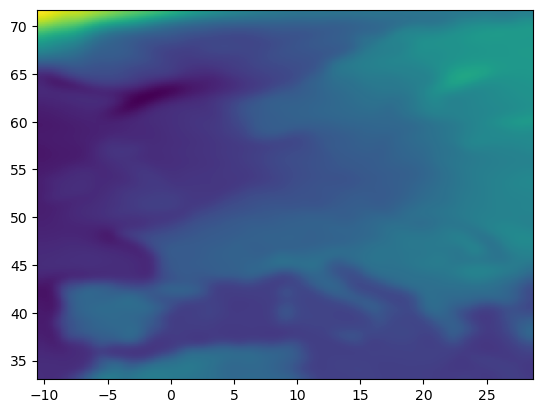

In [8]:
plt.pcolormesh(europe_lon, europe_lat, europe_ttu, shading='nearest')

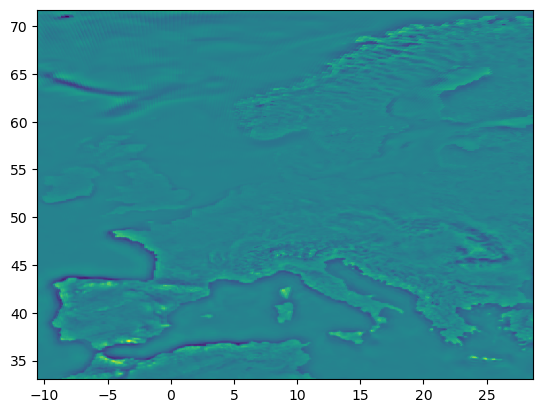

In [9]:
plt.pcolormesh(europe_lon, europe_lat, europe_tt - europe_ttu, shading='nearest')

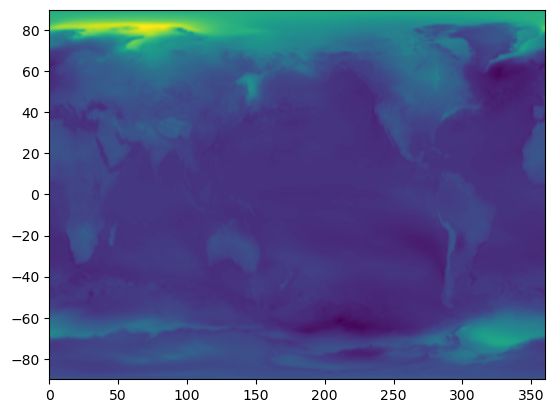

In [12]:
plt.pcolormesh(global_lon, global_lat, global_ttu, shading='nearest')